In [1]:
!pip install numpy_indexed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas
import ast
import os
from PIL import Image
import time
import copy
import numpy_indexed as npi

In [2]:
a = np.asarray([[4, 6, 6],[4, 4, 4]])
b = np.asarray([[6, 6, 6,4],[4, 3, 2, 4]])
count = 0
for i in range(a.shape[0]):
  count += min(npi.in_(a[i, :], b[i, :]).sum(), npi.in_(b[i, :], a[i, :]).sum())
print(count)

5


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Get parts list - use indices of each part as "label", for one-hot encoding
parts_list = []
with open('/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/BerendPartsList') as f:
  for line in f:
    word = line[:len(line) - 1] # get rid of '\n
    parts_list.append(int(word))

print(parts_list)

[4153825, 6104154, 6249125, 4210718, 4181135, 623224, 4621545, 4211166, 4121739, 6062574, 4567338, 4153827, 4539099, 306223, 6229071, 654126, 4550325, 4114319, 4165967, 4527943, 300424, 4181144, 6138173, 6177697, 6022023, 6028324, 6151663, 4121967, 4109995, 4211437, 4647553, 6035291, 306201, 4212454, 6073026, 4211201, 300401, 300421, 300821, 4529247, 4118793, 4504369, 6238674, 6069259, 6223631, 6022064, 300121, 300321, 300124, 4211614, 6225539, 300123, 4649749, 4651236, 4639693, 4157124, 4550348, 6244886, 6075079, 6025026, 4529240, 4558957, 4517992, 4548180, 614321, 6003007, 4211511, 4504381, 6252809, 4181134, 4211412, 300423, 4211149, 4650630, 6074890, 4160403, 4655172, 4211221, 4143562, 6075075, 6004938, 365901, 4211054, 4520632, 300323]


In [5]:
csv_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/CSV/labels.csv'
image_path = '/content/drive/My Drive/APS360 Project/share/Data/Input/Datasets/Berend/Images'
bbox_label_root = '/content/drive/My Drive/APS360 Project/finalOutput'
data = pandas.read_csv(csv_path)
# Convert label col to list of ints of part numbers:
for i in range(len(data["Labels"])):
  label = data["Labels"][i]
  list_row = ast.literal_eval(label)
  data["Labels"][i] = list(map(int, list_row))
# Do same for Color column:
for i in range(len(data["Color"])):
  label = data["Color"][i]
  list_row = ast.literal_eval(label)
  data["Color"][i] = list(map(int, list_row))
print(data["Name"][707])

B_710


In [6]:
# Let us only deal with the first 10 data points:
data_subset = data[:10]
print(data_subset)

  Name     Light  ...            Color                                Labels
0  B_0  daylight  ...  [130, 130, 130]                             [4650630]
1  B_1  daylight  ...  [130, 130, 130]                             [4650630]
2  B_2  daylight  ...  [130, 130, 130]                             [4650630]
3  B_3  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
4  B_4  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
5  B_5  daylight  ...  [130, 130, 130]                    [4650630, 6252809]
6  B_6  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
7  B_7  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
8  B_8  daylight  ...  [130, 130, 130]           [4650630, 6252809, 4211054]
9  B_9  daylight  ...  [130, 130, 130]  [4650630, 6252809, 4211054, 4548180]

[10 rows x 5 columns]


In [7]:
label = data_subset["Name"][9]
print(label)
columns = ["Labels", "x_min", "y_min", "x_max", "y_max"]
bboxes = pandas.read_csv(os.path.join(bbox_label_root, label + '.csv'), skiprows=2, header=None, names=columns)
bboxes_np = bboxes.to_numpy()
print(bboxes_np)
print(type(bboxes_np[0, 0]))

B_9
[[6252809    1393    1643    2467    2598]
 [4548180    2619    1789    2910    2023]
 [4211054    2897    2497    3295    2769]
 [4650630    1551     209    1797     392]]
<class 'numpy.int64'>


In [8]:
class BerendDataset(Dataset):
  # For our dataset, let us accept a CSV file as input
  # + a list of parts, for a one-hot encoding.
  # We will also accept a root directory for images. 
  # We also accept transformations to the image
  def __init__(self, csv_path, parts_list, image_root, transforms, bbox_root):
    self.csv_path = csv_path
    self.parts_list = parts_list
    self.image_root = image_root
    data = pandas.read_csv(csv_path)
    # Convert label col to list of ints of part numbers:
    for i in range(len(data["Labels"])):
      label = data["Labels"][i]
      list_row = ast.literal_eval(label)
      int_list = list(map(int, list_row))
      data["Labels"][i] = list(map(lambda x: parts_list.index(x), int_list))

    # Do same for Color column:
    for i in range(len(data["Color"])):
      label = data["Color"][i]
      list_row = ast.literal_eval(label)
      data["Color"][i] = torch.LongTensor(list(map(int, list_row)))
    
    self.data = data
    self.transforms = transforms
    self.bbox_root = bbox_root
    self.bbox_tracked = {}
    self._BBOX_COL_NAMES = ["Labels", "x_min", "y_min", "x_max", "y_max"]

  def __getitem__(self, idx):
    target = {}
    labels = self.data["Labels"][idx]

    filename = self.data["Name"][idx]
    #print(filename)
    img_path = os.path.join(self.image_root, filename + '.jpg')
    bbox_path = os.path.join(self.bbox_root, filename + '.csv')

    img = Image.open(img_path).convert("RGB")
    if self.transforms is not None:
      img = self.transforms(img)

    target["labels"] = torch.LongTensor(labels)

    if filename in self.bbox_tracked:
      bboxes = self.bbox_tracked[filename]
    else:
      bbox_data = pandas.read_csv(os.path.join(self.bbox_root, filename + '.csv'),
                                  skiprows=2,
                                  header=None,
                                  names=self._BBOX_COL_NAMES)
      bbox_data_np = bbox_data.to_numpy(dtype=np.int_)
      #print("1st = ", bbox_data_np)
      bbox_labels = bbox_data_np[:, 0]
      #print("2nd = ", bbox_labels)
      bbox_targets = bbox_data_np[:, 1:]
      #print("3rd = ", bbox_targets)
      temp = []
      scalex = 330/3072
      scaley = 550/4608
      for b in bbox_targets:
        abox = []
        abox.append(b[0]*scalex)
        abox.append(b[1]*scaley)
        abox.append(b[2]*scalex)
        abox.append(b[3]*scaley)
        temp.append(abox)
      bbox_targets = temp
      #print("mine = ", bbox_targets)
      bboxes = torch.zeros([len(labels), 4], dtype=torch.long)
      #print("4th = ", bboxes)
      for i in range(len(bbox_labels)):
        bboxes[i, :] = torch.LongTensor(bbox_targets[i])
      #print("5th = ", bboxes)
      self.bbox_tracked[filename] = bboxes

    target["boxes"] = bboxes
    
    return img, target
  def __len__(self):
        return len(self.data)

In [9]:
data_transform = transforms.Compose([transforms.Resize((375, 500)), transforms.ToTensor()])
dataset = BerendDataset(csv_path=csv_path, parts_list=parts_list, image_root=image_path, transforms=data_transform, bbox_root=bbox_label_root)

In [10]:
item = dataset[9]

(tensor([[[0.3020, 0.3059, 0.3020,  ..., 0.3529, 0.3647, 0.3922],
         [0.3490, 0.3647, 0.3412,  ..., 0.3529, 0.3843, 0.4157],
         [0.3490, 0.3686, 0.3765,  ..., 0.3882, 0.3961, 0.3843],
         ...,
         [0.4706, 0.4980, 0.5098,  ..., 0.4510, 0.4510, 0.4627],
         [0.4667, 0.4784, 0.4941,  ..., 0.4510, 0.4510, 0.4667],
         [0.4471, 0.4667, 0.4588,  ..., 0.4549, 0.4549, 0.4667]],

        [[0.2706, 0.2627, 0.2588,  ..., 0.3176, 0.3255, 0.3451],
         [0.3137, 0.3176, 0.3098,  ..., 0.3059, 0.3294, 0.3686],
         [0.3098, 0.3216, 0.3451,  ..., 0.3412, 0.3569, 0.3608],
         ...,
         [0.5412, 0.5765, 0.5725,  ..., 0.4549, 0.4549, 0.4549],
         [0.5294, 0.5647, 0.5490,  ..., 0.4471, 0.4471, 0.4667],
         [0.4824, 0.5176, 0.5137,  ..., 0.4471, 0.4392, 0.4588]],

        [[0.1608, 0.1647, 0.1529,  ..., 0.2706, 0.2667, 0.3020],
         [0.1922, 0.2118, 0.1843,  ..., 0.2549, 0.2902, 0.3294],
         [0.1961, 0.2039, 0.2000,  ..., 0.2667, 0.3020, 0

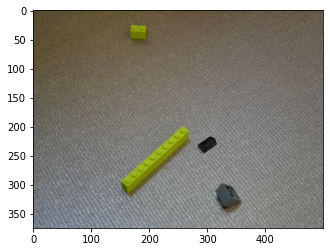

In [11]:
print(item)
image, target = item
img = np.transpose(image, [1,2,0])
print(img.shape)
plt.imshow(img)
print(target["boxes"])

tensor([149, 196, 265, 310])
tensor([281, 213, 312, 241])
tensor([311, 298, 353, 330])
tensor([166,  24, 193,  46])


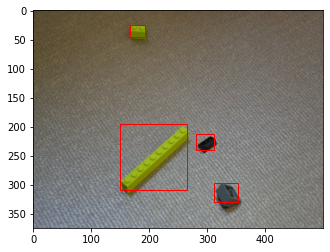

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from torchvision import transforms

im = transforms.ToPILImage()(image).convert("RGB")

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(im)

for b in target["boxes"]:
  print(b)
  # Create a Rectangle patch
  rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)

plt.show()


In [13]:
print(len(dataset))

816


In [14]:
import torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.num_classes = len(parts_list)
print(model)
image = image.unsqueeze(0)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample

In [15]:
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(parts_list), bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=4*len(parts_list), bias=True)

In [16]:
model.eval()
out = model(image)

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


In [17]:
print(out)

[{'boxes': tensor([[161.1691, 247.2451, 261.3728, 302.8613],
        [182.9008, 239.6345, 263.4509, 284.9346],
        [338.4168, 312.4441, 345.9143, 320.6058],
        [180.0719, 244.8254, 234.6021, 323.4376],
        [336.5404, 314.2510, 344.0336, 321.8400],
        [338.3202, 314.7795, 346.1705, 323.8979],
        [334.7912, 312.1912, 346.6062, 323.3971],
        [278.8480, 212.8367, 306.5816, 237.5097],
        [334.3991, 312.6855, 341.7381, 319.6428],
        [153.0367, 215.5610, 221.4240, 318.3168],
        [338.2341, 313.8235, 350.0703, 327.0314],
        [328.4069, 311.9201, 336.6223, 320.6943],
        [332.7386, 314.0806, 340.6768, 321.8868],
        [314.5479, 297.5605, 352.7236, 319.1139],
        [162.5842, 249.5396, 210.5155, 309.5745]], grad_fn=<StackBackward>), 'labels': tensor([45, 45, 45, 45, 45, 45, 45, 73, 45, 15, 45, 45, 45, 73, 45]), 'scores': tensor([0.0769, 0.0732, 0.0683, 0.0634, 0.0615, 0.0589, 0.0571, 0.0566, 0.0565,
        0.0532, 0.0523, 0.0520, 0.0514, 0.

In [18]:
model.train()
img, label = dataset[3]
img = img.unsqueeze(0)
label = [label]
print(img.shape)
print(label)



torch.Size([1, 3, 375, 500])
[{'labels': tensor([73, 68]), 'boxes': tensor([[213,  94, 246, 128],
        [169, 190, 321, 282]])}]


In [19]:
out = model(img, label)

In [20]:
print(out)

{'loss_classifier': tensor(4.2365, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.2155, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0367, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0085, grad_fn=<DivBackward0>)}


In [21]:
out['loss_classifier'].backward()

In [22]:
train_length = int(0.6*len(dataset))
val_length = int(0.2*len(dataset))
test_length = len(dataset) - train_length - val_length
torch.manual_seed(42)
trainset, valset, testst = torch.utils.data.random_split(dataset,
                                                         [train_length, val_length, test_length])

In [23]:
def collate_fn(batch):
  images = []
  targets = []
  for lego in batch:
    images.append(lego[0])
    targets.append(lego[1])
  
  return images, targets



In [24]:
class Batcher:
    def __init__(self, dataset, batch_size=32, drop_last=False):
        self.pics_by_length = {}
        for image, target in dataset:
            # compute the length of the labels:
            llen =target["labels"].shape[0]
            # put the data in the correct key inside self.tweet_by_length
            if llen not in self.pics_by_length:
                self.pics_by_length[llen] = []
            self.pics_by_length[llen].append((image, target),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {llen : torch.utils.data.DataLoader(
                                    legos,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last,   # omit last batch if smaller than batch_size
                                    collate_fn=collate_fn)
            for llen, legos in self.pics_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [25]:
trainloader = Batcher(trainset, batch_size=3, drop_last=True)

In [26]:
val_loader = Batcher(valset, batch_size=3, drop_last=True)

In [27]:
def get_metrics(model, dataloader):
  model.eval()
  count = 0
  total_predictions = 0
  total_labels = 0
  for inputs, target in dataloader:
    for i in range(len(inputs)):
      inputs[i] = inputs[i].cuda()
      target[i]["labels"] = target[i]["labels"].cuda()
      target[i]["boxes"] = target[i]["boxes"].cuda()
  
    outputs = model(inputs)
    for i in range(len(outputs)):
      label = (target[i]["labels"]).cpu().numpy()
      pred = outputs[i]['labels'].cpu().numpy()
      # Get number of true positives:
      count += min(npi.in_(pred, label).sum(), npi.in_(label, pred).sum())
      # Get total number of predictions:
      total_predictions += len(pred)
      total_labels += len(label)
      # print(label, pred)
  # Precisions = TP/(TP + FP)
  if (total_predictions == 0):
    precision = 0
  else:
    precision = count/total_predictions

  if (total_labels == 0):
    recall = 0
  else:
    recall = count/total_labels
  return (precision, recall)

In [28]:
def train_model(model, optimizer, trainloader, val_loader, num_epochs=25):
    torch.manual_seed(42)
    since = time.time()

    epochs, train_loss, train_precs, train_recalls, val_precs, val_recalls = [], [], [], [], [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        n = 0
        for inputs, target in trainloader:
            for i in range(len(inputs)):
              inputs[i] = inputs[i].cuda()
              target[i]["labels"] = target[i]["labels"].cuda()
              target[i]["boxes"] = target[i]["boxes"].cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs, target)
                #preds = torch.max(outputs, 1)
                class_loss = outputs['loss_classifier'] + outputs['loss_box_reg'] + outputs['loss_objectness'] + outputs['loss_rpn_box_reg']

                class_loss.backward()
                optimizer.step()
                # statistics
                running_loss += class_loss.item()
                #running_corrects += torch.sum(preds == target)
                n+=1
            #print("Epoch {}, iteration {}".format(epoch, n))
                  

        torch.set_grad_enabled(False)
        epoch_loss = running_loss / n
        train_loss.append(epoch_loss)
        epochs.append(epoch)
        train_prec, train_recall = get_metrics(model, trainloader)
        val_prec, val_recall = get_metrics(model, val_loader)
        train_precs.append(train_prec)
        val_precs.append(val_prec)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)

        print('Training - {} Loss: {:.4f} Prec: {:.4f} Recall: {:.4f}'.format(epoch, epoch_loss, train_prec, train_recall))
        print('Validation - {} Prec: {:.4f} Recall: {:.4f}'.format(epoch, val_prec, val_recall))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    """
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    """
    # plotting
    plt.title("Training Loss Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Precision Curve")
    plt.plot(epochs, train_precs, label="Train")
    plt.plot(epochs, val_precs, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Recall Curve")
    plt.plot(epochs, train_recalls, label="Train")
    plt.plot(epochs, val_recalls, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.legend(loc='best')
    plt.show()
    return model

In [29]:
criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)
optimizer_ft = optim.SGD(model.parameters(), lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
model = model.cuda()

Epoch 0/49
----------
Training - 0 Loss: 1.4312 Prec: 0.0405 Recall: 0.1027
Validation - 0 Prec: 0.0415 Recall: 0.1014

Epoch 1/49
----------
Training - 1 Loss: 1.2212 Prec: 0.0878 Recall: 0.2074
Validation - 1 Prec: 0.0798 Recall: 0.1684

Epoch 2/49
----------
Training - 2 Loss: 1.0681 Prec: 0.0839 Recall: 0.3743
Validation - 2 Prec: 0.0752 Recall: 0.3179

Epoch 3/49
----------
Training - 3 Loss: 0.9717 Prec: 0.1229 Recall: 0.5362
Validation - 3 Prec: 0.1111 Recall: 0.4536

Epoch 4/49
----------
Training - 4 Loss: 0.9005 Prec: 0.1261 Recall: 0.6500
Validation - 4 Prec: 0.1166 Recall: 0.5928

Epoch 5/49
----------
Training - 5 Loss: 0.8312 Prec: 0.1379 Recall: 0.7668
Validation - 5 Prec: 0.1254 Recall: 0.7199

Epoch 6/49
----------
Training - 6 Loss: 0.7597 Prec: 0.1535 Recall: 0.8128
Validation - 6 Prec: 0.1353 Recall: 0.7474

Epoch 7/49
----------
Training - 7 Loss: 0.7056 Prec: 0.1524 Recall: 0.8857
Validation - 7 Prec: 0.1384 Recall: 0.8471

Epoch 8/49
----------
Training - 8 Loss:

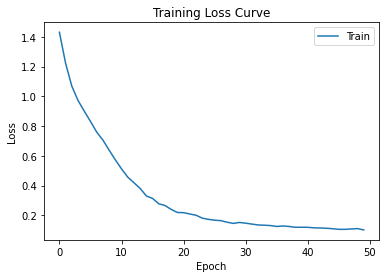

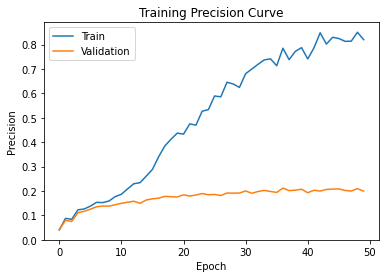

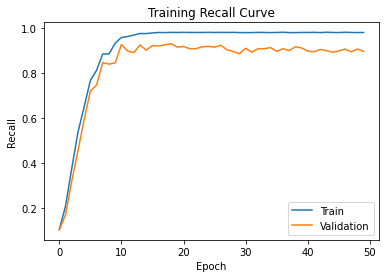

In [30]:
model_ft = train_model(model, optimizer_ft, trainloader, val_loader,
                       num_epochs=50)

115
tensor([[181.0524,  83.6646, 203.1798, 123.6699],
        [154.2501, 247.6005, 193.2382, 294.6383],
        [300.0608, 229.5726, 327.7635, 256.0174],
        [302.8447, 230.3604, 329.9482, 255.8553]], device='cuda:0')
[63, 53, 60, 80]


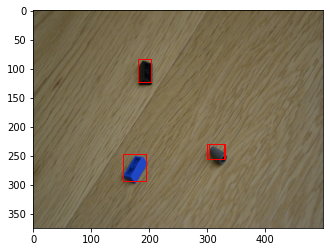

In [31]:
model.eval()
#6227
rand_ind = np.random.randint(len(dataset))
print(rand_ind)
item = dataset[401]
image, target = item
image = image.unsqueeze(0)
out = model(image.cuda())
image = image.squeeze(0)
im = transforms.ToPILImage()(image).convert("RGB")
print(out[0]["boxes"])
label = out[0]["labels"].tolist()
print(label)
fig,ax = plt.subplots(1)
ax.imshow(im)
for a, b in enumerate(out[0]["boxes"]):
  #print(label[a])
  if label[a] == 53 or label[a] == 60 or label[a] == 63:
    pass
  # Create a Rectangle patch
  rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(rect)


tensor([63, 53, 60])
tensor([[181,  88, 203, 125],
        [153, 244, 194, 290],
        [301, 227, 330, 259]])


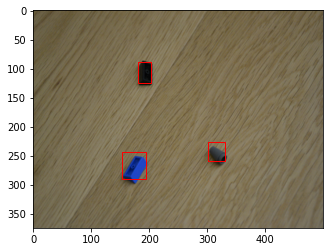

In [32]:
item = dataset[401]
image, target = item
img = np.transpose(image, [1,2,0])
print(target["labels"])
fig,ax = plt.subplots(1)
ax.imshow(im)
print(target["boxes"])
label = target["labels"].tolist()
for a, b in enumerate(target["boxes"]):
  rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

[63, 38, 12, 15, 31, 31, 77, 77, 63, 31, 26, 7, 52, 82, 60, 15, 55, 57, 7, 67, 77, 77, 37, 55, 80, 9, 40, 31, 31, 75, 63, 26, 1, 77, 63, 37, 55, 80, 52, 37, 52, 82, 59, 7, 26, 13, 79, 39, 74, 55, 1, 63, 37, 44, 30, 60]


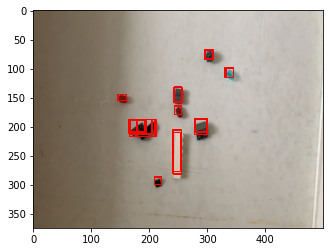

In [33]:
data_transform = transforms.Compose([transforms.Resize((375, 500)), transforms.ToTensor()])
newdata = Image.open("/content/drive/My Drive/APS360 Project/new_data.jpg").convert("RGB")
newdata = data_transform(newdata)
model.eval()
newdata = newdata.unsqueeze(0)
out = model(newdata.cuda())
newdata = newdata.squeeze(0)
im = transforms.ToPILImage()(newdata).convert("RGB")
label = out[0]["labels"].tolist()
print(label)
fig,ax = plt.subplots(1)
ax.imshow(im)
for a, b in enumerate(out[0]["boxes"]):
  rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)


In [34]:
#torch.save(model.state_dict(), "/content/drive/My Drive/APS360 Project/Models/RCNN/weights_adam")
torch.save(model.state_dict(), "/content/drive/My Drive/APS360 Project/Models/RCNN/weights_SGD3")

In [35]:
def eval_model(model, testloader):
    torch.manual_seed(42)
    since = time.time()

    epochs, train_loss, train_precs, train_recalls, val_precs, val_recalls = [], [], [], [], [], []
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    n = 0
    for inputs, target in trainloader:
        for i in range(len(inputs)):
          inputs[i] = inputs[i].cuda()
          target[i]["labels"] = target[i]["labels"].cuda()
          target[i]["boxes"] = target[i]["boxes"].cuda()

    torch.set_grad_enabled(False)
    test_prec, test_recall = get_metrics(model, testloader)
    print('Testing Results Prec: {:.4f} Recall: {:.4f}'.format(test_prec, test_recall))
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [36]:
test_loader = Batcher(testst, batch_size=3, drop_last=True)

In [37]:
eval_model(model, test_loader)

Testing Results Prec: 0.1979 Recall: 0.8995

Training complete in 0m 19s


In [43]:
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=len(parts_list), bias=True)
model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=4*len(parts_list), bias=True)
model.load_state_dict(torch.load("/content/drive/My Drive/APS360 Project/Models/RCNN/weights_SGD3"))

<All keys matched successfully>

In [44]:
data_transform = transforms.Compose([transforms.Resize((375, 500)), transforms.ToTensor()])
newdata = Image.open("/content/drive/My Drive/APS360 Project/new_data.jpg").convert("RGB")
newdata = data_transform(newdata)

In [45]:
model.eval()
model.cuda()
newdata = newdata.unsqueeze(0)
out = model(newdata.cuda())
newdata = newdata.squeeze(0)

63 :  4548180
38 :  300821
12 :  4539099
15 :  654126
31 :  6035291
77 :  4211221
26 :  6151663
7 :  4211166
52 :  4649749
82 :  4211054
60 :  4529240
55 :  4157124
57 :  6244886
67 :  4504381
37 :  300421
80 :  6004938
9 :  6062574
40 :  4118793
75 :  4160403
1 :  6104154
59 :  6025026
13 :  306223
79 :  6075075
39 :  4529247
74 :  6074890
44 :  6223631
30 :  4647553


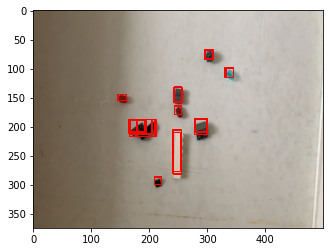

In [46]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from torchvision import transforms

im = transforms.ToPILImage()(newdata).convert("RGB")
label = out[0]["labels"].tolist()
parts_found = []
for i, ind in enumerate(label):
  if (label[i], parts_list[ind]) not in parts_found:
    print(label[i], ": ", parts_list[ind])
    parts_found.append((label[i], parts_list[ind]))

fig,ax = plt.subplots(1)
ax.imshow(im)
for a, b in enumerate(out[0]["boxes"]):
  rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)


(63, 4548180)
(38, 300821)
(12, 4539099)
(15, 654126)
(31, 6035291)
(77, 4211221)
(26, 6151663)
(7, 4211166)
(52, 4649749)
(82, 4211054)
(60, 4529240)
(55, 4157124)
(57, 6244886)
(67, 4504381)
(37, 300421)
(80, 6004938)
(9, 6062574)
(40, 4118793)
(75, 4160403)
(1, 6104154)
(59, 6025026)
(13, 306223)
(79, 6075075)
(39, 4529247)
(74, 6074890)
(44, 6223631)
(30, 4647553)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


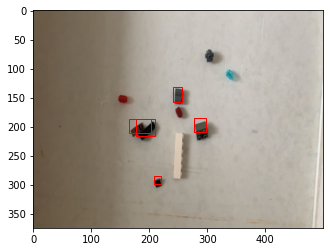

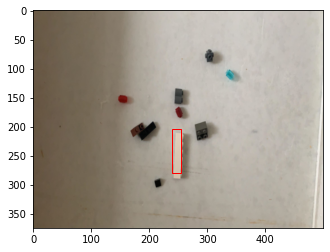

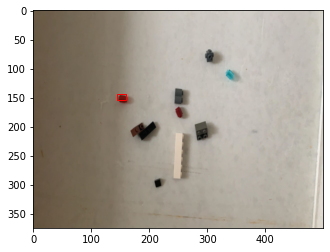

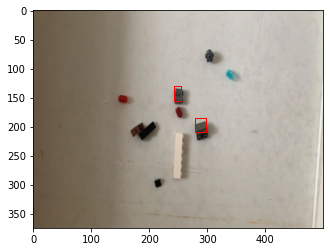

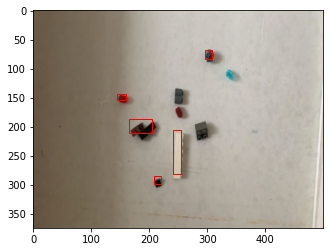

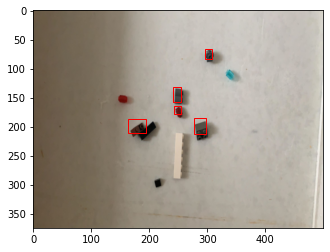

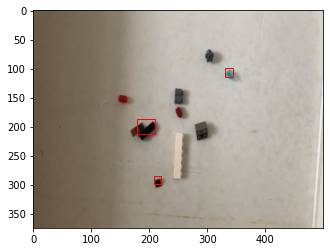

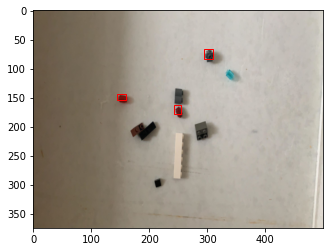

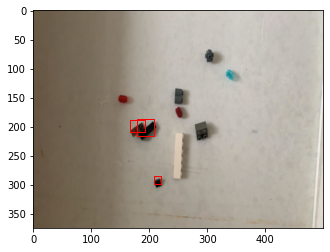

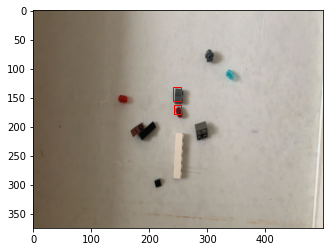

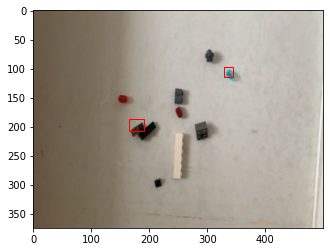

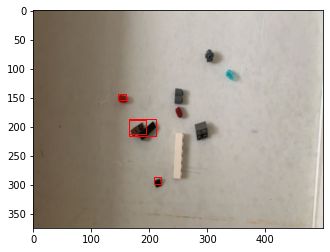

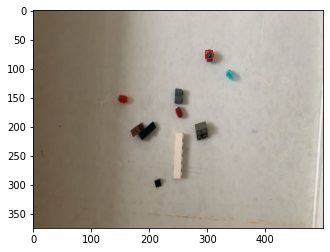

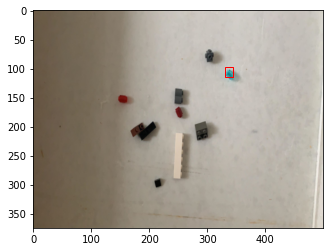

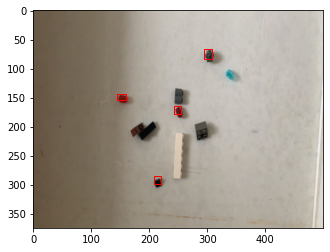

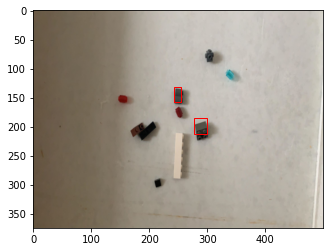

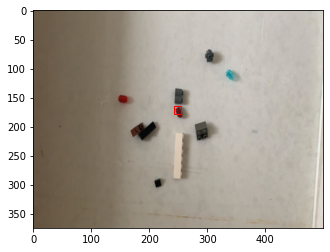

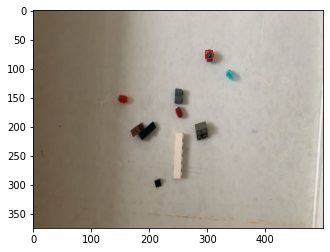

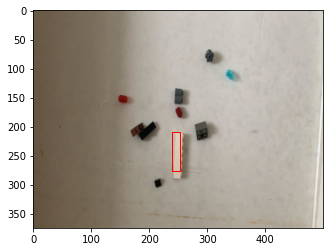

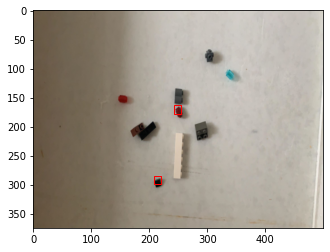

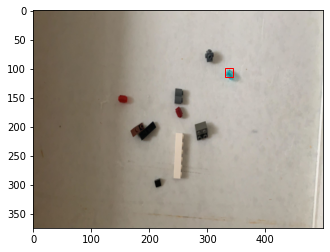

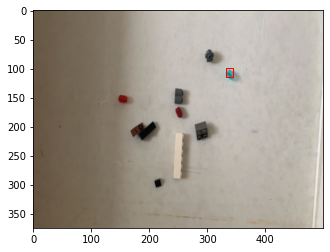

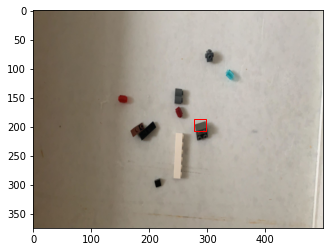

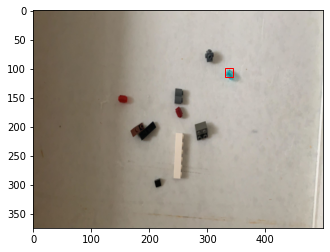

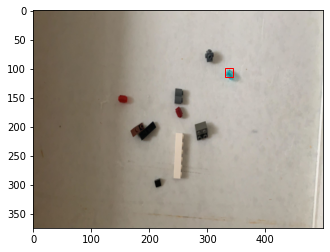

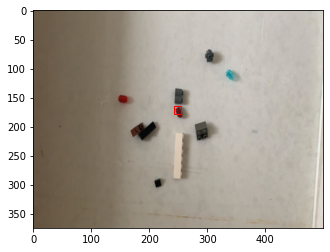

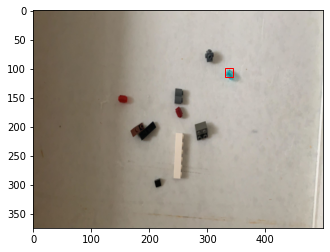

In [52]:
for i, tup in enumerate(parts_found):
  im = transforms.ToPILImage()(newdata).convert("RGB")
  fig, ax = plt.subplots(1)
  print(tup)
  for a, b in enumerate(out[0]["boxes"]):
    if label[a] == tup[0]:
      rect = patches.Rectangle((b[0],b[1]),(b[2]-b[0]), (b[3]-b[1]),linewidth=1,edgecolor='r',facecolor='none')
      ax.add_patch(rect)
  ax.imshow(im)
  #fig.imsave("./RCNNoutput/"+str(tup[1])+".png", im)